In [15]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
aux_data = pd.read_csv('data/train.csv')
print(aux_data.shape)

n = 65
img_name = aux_data.iloc[n, 0]
actual_data = aux_data.iloc[n, 1:]
actual_data = np.asarray(actual_data, dtype=float)

print(f"Image name: {img_name}.jpeg")
print(f"Landmarks shape: {actual_data.shape}")
print(f"First 4 data points: {actual_data[:4]}")

(43363, 170)
Image name: 15673271.jpeg
Landmarks shape: (169,)
First 4 data points: [  8.97455406 603.1428833   59.2142868   32.97442627]


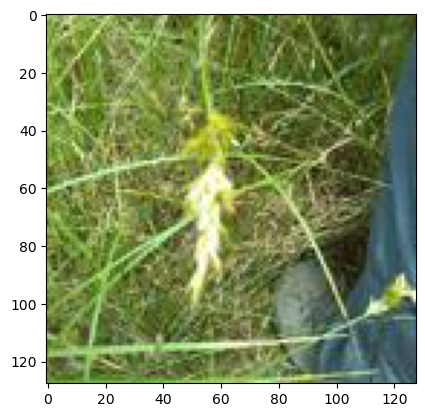

In [17]:
plt.figure()
plt.imshow(io.imread(os.path.join('data/train_images', str(img_name) + ".jpeg")))
plt.show()

In [18]:
class INaturalist(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, pd_df, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.aux_dataframe = pd_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.aux_dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                str(self.aux_dataframe.iloc[idx, 0]) + ".jpeg")
        image = io.imread(img_name)
        aux_data = self.aux_dataframe.iloc[idx, 1:-6]
        aux_target = self.aux_dataframe.iloc[idx, -6:]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(aux_data).type(torch.float32), torch.tensor(aux_target).type(torch.float32),torch.tensor(self.aux_dataframe.iloc[idx, 0]).type(torch.int32)

In [19]:
from sklearn.model_selection import train_test_split

traincsv = pd.read_csv('data/train.csv')
trainset, valset = train_test_split(traincsv, test_size=0.15)

In [20]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

X_train = trainset.iloc[:, 1:-6]
y_train = trainset.iloc[:, -6:]
X_val = valset.iloc[:, 1:-6]
y_val = valset.iloc[:, -6:]
train_ids = trainset.iloc[:, 0]
val_ids = valset.iloc[:, 0]

In [21]:
import numpy as np

other_valset = valset.copy()

y_train = np.log10(y_train)
y_val = np.log10(y_val)

mean_train = y_train.mean()
std_train = y_train.std()
mean_val = y_val.mean()
std_val = y_val.std()
max_train = y_train.max()
min_train = y_train.min()

# trainset = trainset[~((y_train - mean_train) > 3 * std_train).any(axis=1)]
y_train = (y_train - min_train) / (max_train - min_train)
# valset = valset[~((y_val - mean_val) > 3 * std_val).any(axis=1)]
y_val = (y_val - min_train) / (max_train - min_train)


In [22]:
trainset = pd.concat([train_ids, X_train, y_train], axis=1)
valset = pd.concat([val_ids, X_val, y_val], axis=1)

In [23]:
trainset.shape, valset.shape

((36858, 170), (6505, 170))

In [24]:
testcsv = pd.read_csv('data/test.csv')

train_dataset = INaturalist(trainset, 'data/train_images', transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

val_dataset = INaturalist(valset, 'data/train_images', transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

test_dataset = INaturalist(testcsv, 'data/test_images', transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

val_dataset_unmodified = INaturalist(other_valset, 'data/train_images', transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=4)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                shuffle=True, num_workers=4)
validation_loader_unmodified = torch.utils.data.DataLoader(val_dataset_unmodified, batch_size=batch_size,
                                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

for i, data in enumerate(train_loader):
    inputs, aux_data, aux_labels, idx = data
    print(f"Input shape: {inputs.shape}")
    print(f"Aux data shape: {aux_data.shape}")
    print(f"Aux labels shape: {aux_labels.shape}")
    break

Input shape: torch.Size([64, 3, 224, 224])
Aux data shape: torch.Size([64, 163])
Aux labels shape: torch.Size([64, 6])


In [25]:
import torch
import torch.nn as nn
from torchvision import models

class VisionTransformerWithNumericalData(nn.Module):
    def __init__(self, num_outputs, num_numerical_features, hidden_dim_numerical, hidden_dim_classifier):
        super(VisionTransformerWithNumericalData, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)  
        # self.feature_extractor = nn.Sequential(*list(self.vit.children())[:-1])
        # self.conv = self.feature_extractor[0]
        # self.encoder = self.feature_extractor[1]
        
        self.numerical_transform = nn.Sequential(
            nn.Linear(num_numerical_features, 512),
            nn.ReLU(),
            # nn.Dropout(0.1),
            # nn.Linear(num_numerical_features, 512),
            # nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(512, hidden_dim_numerical),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(hidden_dim_numerical, hidden_dim_numerical),
            nn.ReLU(),
        )
    
        self.classifier = nn.Sequential(
                    nn.Linear(hidden_dim_numerical + 1000, hidden_dim_classifier),
                    nn.ReLU(),
                    # nn.Dropout(0.1),
                    nn.Linear(hidden_dim_classifier, hidden_dim_classifier),
                    nn.ReLU(),
                    # nn.Dropout(0.1),
                    # nn.Linear(512, 256),
                    # nn.ReLU(),
                    # nn.Dropout(0.1),
                    nn.Linear(hidden_dim_classifier, num_outputs))


    def forward(self, images, numerical_features):
        vit_features = self.vit(images)
        # n = x.shape[0]
        # batch_class_token = self.vit.class_token.expand(n, -1, -1)
        # x = torch.cat((batch_class_token, x), dim=1)
        # x = self.encoder(x)
        # vit_features = x[:, 0]
        vit_features = vit_features.view(vit_features.size(0), -1)
        numerical_features = self.numerical_transform(numerical_features)
        
        combined_features = torch.cat((vit_features, numerical_features), dim=1)
        output = self.classifier(combined_features)
        return output

model = VisionTransformerWithNumericalData(num_outputs=6, num_numerical_features=163, hidden_dim_numerical=1024, hidden_dim_classifier=1024).to('cuda')
# print(sum(p.numel() for p in model.parameters() if p.requires_grad))
images = torch.randn(64, 3, 224, 224).to('cuda')
numerical_features = torch.randn(64, 163).to('cuda')
model(images, numerical_features).shape

torch.Size([64, 6])

In [26]:
class VisionTransformerWithNumericalDataSmaller(nn.Module):
    def __init__(self, num_outputs, num_vit_features, num_numerical_features, hidden_dim_classifier):
        super(VisionTransformerWithNumericalDataSmaller, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)  
        self.feature_extractor = nn.Sequential(*list(self.vit.children())[:-1])
        self.conv = self.feature_extractor[0]
        self.encoder = self.feature_extractor[1]
        
        self.feature_transform = nn.Sequential(
            nn.Linear(768, 3072),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(3072, num_vit_features),
        )
    
        self.classifier = nn.Sequential(
                    nn.Linear(num_numerical_features + num_vit_features, hidden_dim_classifier),
                    nn.ReLU(),
                    nn.Dropout(0.4),
                    nn.Linear(hidden_dim_classifier, 256),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(64, num_outputs)
                )


    def forward(self, images, numerical_features):
        x = self.vit._process_input(images)
        n = x.shape[0]
        batch_class_token = self.vit.class_token.expand(n, -1, -1)
        x = torch.cat((batch_class_token, x), dim=1)
        x = self.encoder(x)
        vit_features = x[:, 0]
        vit_features = vit_features.view(vit_features.size(0), -1)
        v_features = self.feature_transform(vit_features)
        
        combined_features = torch.cat((v_features, numerical_features), dim=1)
        output = self.classifier(combined_features)
        return output
    
# model = VisionTransformerWithNumericalDataSmaller(num_outputs=6, num_vit_features=512, num_numerical_features=163, hidden_dim_classifier=512).to('cuda')
# images = torch.randn(64, 3, 224, 224).to('cuda')
# numerical_features = torch.randn(64, 163).to('cuda')
# model(images, numerical_features).shape

In [27]:
import torch.optim as optim
import torcheval.metrics as metrics
# Define lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
train_metric = metrics.R2Score()
val_metric = metrics.R2Score()

# Set number of epochs
num_epochs = 15

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training phase
    model.train()
    for i, data in enumerate(train_loader):
        inputs, aux_data, aux_labels, _ = data
        inputs = inputs.to("cuda")
        aux_data = aux_data.to("cuda")
        aux_labels = aux_labels.to("cuda")
        
        # Zero the gradients
        optimizer.zero_grad()
        outputs = model(inputs, aux_data)
        loss = criterion(outputs, aux_labels)
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        train_metric.update(outputs, aux_labels)
        
        
        # Print training progress
        if i % 100 == 99:
            # Compute training accuracy
            r2_score = train_metric.compute()
            train_accuracies.append(r2_score)
            print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss / 100:.6f} R2 Score: {r2_score:.6f}")
            train_metric.reset()
            running_loss = 0.0

        if i % 200 == 199:
    
            # Validation phase
            model.eval()
            
            with torch.no_grad():
                r2_score_avg = 0
                for data in validation_loader:
                    inputs, aux_data, aux_labels,_ = data
                    inputs = inputs.to("cuda")
                    aux_data = aux_data.to("cuda")
                    aux_labels = aux_labels.to("cuda")
                    
                    # Forward pass
                    outputs = model(inputs, aux_data)
                    
                    # Compute validation accuracy
                    val_metric.update(outputs, aux_labels)

                r2_score_val = val_metric.compute()
                val_accuracies.append(r2_score_val)
                print(f"Epoch {epoch+1} - Validation R2 Score: {r2_score_val:.6f}")
                val_metric.reset()
                
            torch.save(model.state_dict(), f"best_checkpoints/model_{epoch+1}_{i}.pt")

print("Training finished!")

[Epoch 1, Batch 100] Loss: 10.980832 R2 Score: -1230.153687
[Epoch 1, Batch 200] Loss: 0.025822 R2 Score: -0.318263
Epoch 1 - Validation R2 Score: -0.191528
[Epoch 1, Batch 300] Loss: 0.025585 R2 Score: -0.265059
[Epoch 1, Batch 400] Loss: 0.023763 R2 Score: -0.149786
Epoch 1 - Validation R2 Score: -0.101475
[Epoch 1, Batch 500] Loss: 0.023699 R2 Score: -0.166680
[Epoch 2, Batch 100] Loss: 0.023127 R2 Score: -0.100739
[Epoch 2, Batch 200] Loss: 0.022658 R2 Score: -0.086321
Epoch 2 - Validation R2 Score: -0.108160
[Epoch 2, Batch 300] Loss: 0.021699 R2 Score: -0.052717
[Epoch 2, Batch 400] Loss: 0.022793 R2 Score: -0.094592
Epoch 2 - Validation R2 Score: -0.063128
[Epoch 2, Batch 500] Loss: 0.021405 R2 Score: -0.046383
[Epoch 3, Batch 100] Loss: 0.021366 R2 Score: -0.001125
[Epoch 3, Batch 200] Loss: 0.020305 R2 Score: 0.016505
Epoch 3 - Validation R2 Score: -0.006229
[Epoch 3, Batch 300] Loss: 0.020696 R2 Score: 0.004394
[Epoch 3, Batch 400] Loss: 0.020425 R2 Score: -0.008661
Epoch 3 -

In [28]:
state = {
    'epoch': epoch+51,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
}

torch.save(state, "first_model_low_batch_checkpoints/model_future_training.pt")

RuntimeError: Parent directory first_model_low_batch_checkpoints does not exist.

In [ ]:
model.load_state_dict(torch.load("smaller_model_checkpoints/model_9_399.pt"))
model.eval()

retransform = True

predictions = []
metric = metrics.R2Score()
if retransform:
    dataloader = test_loader
else:
    dataloader = validation_loader_unmodified
with torch.no_grad():
    for data in dataloader:
        inputs, aux_data, aux_labels, id = data
        inputs = inputs.to("cuda")
        aux_data = aux_data.to("cuda")
        aux_labels = aux_labels.to("cuda")
        id = id.to("cuda")

        
        # Forward pass
        if retransform:
            aux = torch.cat([aux_data, aux_labels], dim=1)
            outputs = model(inputs, aux)
            transformed_vals = (max_train - min_train).to_numpy() * outputs.cpu().numpy() + min_train.to_numpy()
            # transformed_vals = np.float_power(10, transformed_vals)
            outputs = np.concatenate([id.view(-1, 1).cpu().numpy(), transformed_vals], axis=1)
            predictions.append(outputs)
            if (outputs[:, 0] == 196238016).any():
                print(aux_data[:, 0])
        else:
            outputs = model(inputs, aux_data)
            int_val = torch.tensor(max_train - min_train) * outputs.cpu() + torch.tensor(min_train)
            transformed_ouputs = torch.pow(10, int_val)
            metric.update(transformed_ouputs.cpu(), aux_labels.cpu())
            
if retransform:

    predictions = np.concatenate(predictions)
    testdf = pd.read_csv('data/test.csv')
    output_columns = ["id", "X4", "X11", "X18", "X26", "X50", "X3112"]
    output_df = pd.DataFrame(predictions, columns=output_columns)
    output_df = output_df.astype({"id": "int64"})
    print(output_df['id'].duplicated())
    output_df.to_csv("test_results.csv", index=False)
else:
    x = metric.compute()
    print(x)

0       False
1       False
2       False
3       False
4       False
        ...  
6386    False
6387    False
6388    False
6389    False
6390    False
Name: id, Length: 6391, dtype: bool
